<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 02: 大语言模型中 DPO 与 PPO 算法对比实验

## 实验背景

在大语言模型(LLM)和多模态大模型的发展历程中,**如何使模型生成的内容更好地符合人类价值观和偏好**一直是核心挑战之一。强化学习从人类反馈(RLHF)技术为解决这一问题提供了有效路径,而其中最具代表性的两种方法便是 **PPO(Proximal Policy Optimization, 近端策略优化)** 和 **DPO(Direct Preference Optimization, 直接偏好优化)**。

### PPO vs DPO 核心差异

**PPO 算法 (近端策略优化)**:
- 作为强化学习领域的经典方法，在 RLHF (人类反馈强化学习) 中被 OpenAI 等机构广泛采用
- 采用三阶段训练流程：监督微调 → 奖励模型训练 → 强化学习优化
- 通过显式的奖励模型引导策略优化，能够稳定地提升模型性能
- **优势**: 训练过程相对稳定，有成熟的理论基础
- **劣势**: 流程复杂，需要训练独立的奖励模型，计算成本高

**DPO 算法 (直接偏好优化)**:
- 直接从人类偏好数据中学习策略，无需训练独立的奖励模型
- 采用偏好数据直接优化策略，将策略优化问题转化为二分类问题
- **优势**: 
  - 简化训练流程，只需监督微调+偏好优化两个阶段
  - 避免了奖励模型的设计和训练，减少计算开销
  - 实现更简单，训练效率更高
- **劣势**: 
  - 对偏好数据质量要求较高
  - 缺乏显式的奖励信号，难以进行细粒度控制

### 实验目标

本实验将使用 **Qwen3-0.6B** 作为基础模型,通过构建简化的文本生成任务环境,从以下维度深入对比两种算法:
1. 训练稳定性(奖励/损失曲线变化)
2. 生成文本质量(流畅性、多样性、相关性)
3. 实现复杂度与训练效率

## 1. 实验环境设置

首先加载预训练语言模型并配置实验环境。本实验选用 **Qwen3-0.6B** 模型,该模型由阿里巴巴通义千问团队开源,具有以下特点:
- 参数规模适中(0.6B),适合快速实验迭代
- 计算资源需求较低,单卡 GPU 即可完成训练

In [ ]:
from huggingface_hub import snapshot_download
snapshot_download(repo_id="Qwen/Qwen3-0.6B", repo_type="model", # {'dataset', 'model'}
                  local_dir="your_local_dir/Qwen/Qwen3-0.6B",  # 指定本地路径
                  local_dir_use_symlinks=False, resume_download=True,
                  token='your huggingface token',						# token获取地址：https://huggingface.co/settings/tokens
                  endpoint='https://hf-mirror.com' 
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM


# 设置计算设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 加载 Qwen3-0.6B 模型配置和分词器
model_name = "your_local_dir/Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token  # 设置填充标记

# 加载模型配置（用于获取 hidden_size 等参数）
from transformers import AutoConfig
model_config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
print(f"Qwen3-0.6B 配置加载完成 (hidden_size={model_config.hidden_size})")

h:\conda_envs\my_llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda
Qwen3-0.6B 配置加载完成 (hidden_size=1024)


## 2. 文本生成环境

为了对比 PPO 和 DPO，我们创建一个简化的文本生成环境。这个环境模拟了对话系统或文本补全任务的基本流程，其中模型需要根据给定的提示生成合适的响应。

In [2]:
class TextGenerationEnv:
    def __init__(self, prompt_list, max_length=30):
        """
        文本生成环境（用于评估生成文本质量）
        :param prompt_list: 提示文本列表
        :param max_length: 生成文本的最大 token 数量
        """
        self.prompts = prompt_list
        self.max_length = max_length
        self.current_prompt = None
        self.generated_text = ""
        self.token_count = 0
        
    def reset(self):
        """重置环境，随机选择一个提示"""
        self.current_prompt = np.random.choice(self.prompts)
        self.generated_text = ""
        self.token_count = 0
        return self.current_prompt
    
    def step(self, action):
        """
        执行一个动作（生成一个 token）
        :param action: token ID
        :return: 生成文本, 奖励, 是否完成
        """
        # 解码 token 并添加到生成文本
        token = tokenizer.decode([action], skip_special_tokens=False)
        self.generated_text += token
        self.token_count += 1
        
        # 检查终止条件：达到最大 token 数或生成结束标记
        done = (self.token_count >= self.max_length or 
                action == tokenizer.eos_token_id)
        
        # 仅在序列完成时计算最终奖励，中间步骤奖励为 0
        reward = self._calculate_reward() if done else 0.0
        
        return self.generated_text, reward, done
    
    def calculate_reward_for_text(self, generated_text):
        """
        为给定的生成文本计算奖励（用于 PPO 训练）
        :param generated_text: 完整生成的文本
        :return: 奖励值
        """
        self.generated_text = generated_text
        return self._calculate_reward()
    
    def _calculate_reward(self):
        """计算生成文本的奖励（简化版本）"""
        # TODO 评估指标: 可以考虑添加更多质量指标，如困惑度、BLEU 分数等
        # 在实际应用中，这里可以使用奖励模型或人工评估
        # 这里使用简单的启发式规则评估生成质量
        text = self.generated_text.lower().strip()
        prompt = self.current_prompt.lower().strip()
        
        # 如果生成为空，返回负奖励
        if not text or len(text) < 3:
            return -1.0
        
        # 1. 长度奖励：鼓励生成适当长度的文本（避免过长或过短）
        text_len = len(text.split())
        if text_len < 5:
            length_reward = text_len / 5.0 * 0.5  # 太短惩罚
        elif text_len > 50:
            length_reward = max(0.0, 1.0 - (text_len - 50) / 50.0)  # 太长惩罚
        else:
            length_reward = 1.0
        
        # 2. 多样性奖励：鼓励使用不同的词汇
        words = text.split()
        unique_words = len(set(words))
        diversity_reward = min(unique_words / max(1, len(words) * 0.7), 1.0)
        
        # 3. 流畅性奖励：检查常见连接词和标点
        fluency_score = 0.0
        # 检查连接词
        connectors = ["and", "the", "but", "however", "therefore", "because", "also"]
        connector_count = sum(1 for word in connectors if word in text)
        fluency_score += min(connector_count / 3.0, 0.5)
        
        # 检查是否有合理的句子结构（简单判断：包含空格和标点）
        if any(p in text for p in ['.', '!', '?', ',']):
            fluency_score += 0.3
        fluency_reward = min(fluency_score, 1.0)
        
        # 4. 质量惩罚：检查重复和无意义内容
        repetition_penalty = 0.0
        # 检查连续重复的词
        for i in range(len(words) - 1):
            if i < len(words) - 1 and words[i] == words[i+1]:
                repetition_penalty += 0.1
        
        # 检查是否只是重复提示词
        prompt_overlap = len(set(prompt.split()) & set(words))
        if prompt_overlap > len(set(prompt.split())) * 0.8:
            repetition_penalty += 0.3
        
        # 加权组合各项奖励
        total_reward = (
            length_reward * 0.25 + 
            diversity_reward * 0.25 + 
            fluency_reward * 0.3 +
            0.2  # 基础奖励
        ) - min(repetition_penalty, 0.5)
        
        # 确保奖励在合理范围内
        return max(-1.0, min(1.0, total_reward))

## 3. PPO 原理与实现

PPO 算法的核心思想是通过限制策略更新的幅度来保证训练的稳定性。它使用一个裁剪函数来防止策略更新过大，从而避免训练过程中的剧烈波动。PPO 的目标函数可以表示为：

$$L^{CLIP}(\theta) = \mathbb{E}_t[\min(r_t(\theta)A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)A_t)]$$

其中：

- $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$ 是策略比
- $A_t$ 是优势函数，表示当前动作相对于平均水平的优势
- $\epsilon$ 是裁剪参数，通常设为 0.1-0.3

这个目标函数的核心思想是：当策略比 $r_t(\theta)$ 偏离 1 太远时，通过裁剪限制其影响，从而避免过大的策略更新。

在大语言模型场景中，PPO 通常用于 RLHF 流程，通过奖励模型来优化策略。我们实现一个简化的 PPO 训练器：

![alt text](./images/Code02-DPOPPO-ppo.png)

reference: [图解大模型RLHF系列之：人人都能看懂的PPO原理与源码解读 - 猛猿的文章 - 知乎](https://zhuanlan.zhihu.com/p/677607581)

In [3]:
class PPOPolicy(nn.Module):
    """Policy model
    说明:
    - 这里直接复用预训练的自回归语言模型作为策略 π(a|s)
    - 我们仅做两类访问: (1) logits (用于动作分布与采样) (2) 隐藏状态最后一个 token 的向量 (用于价值估计)
    为什么只取最后一个 token 的隐藏状态:
    - 自回归生成时当前状态的充分统计量可由最后位置的隐藏向量近似表示 (包含前序所有 token 语义压缩)
    - 减少额外投影开销, 避免对整段序列再做池化处理
    """
    def __init__(self, base_model):
        super(PPOPolicy, self).__init__()
        self.model = base_model
        
    def forward(self, input_ids, attention_mask=None):
        return self.model(input_ids, attention_mask=attention_mask)
    
    def get_logits(self, input_ids, attention_mask=None):
        """获取语言模型的输出 logits
        返回形状: [batch, seq_len, vocab_size]
        用途: 构建 Categorical 分布采样下一个 token 或计算 log_prob
        """
        outputs = self.model(input_ids, attention_mask=attention_mask)
        return outputs.logits
    
    def get_hidden_states(self, input_ids, attention_mask=None):
        """获取语言模型最后一层的隐藏状态最后一个 token 的向量
        返回形状: [batch, hidden_size]
        用途: 作为价值网络 V(s) 的输入
        注意: 只调用最后一层避免无谓的多层池化; output_hidden_states=True 会返回所有层
        """
        outputs = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return outputs.hidden_states[-1][:, -1, :]

class PPO:
    """PPO 算法实现 (加入 KL 正则 / Entropy 奖励 / Value Clipping / GAE(λ))
    设计概览:
    1. 经验采样 generate(): Actor 采样 token + Critic 估值, 不构建梯度图 (no_grad)
    2. update():
       (a) 组装批次 (advantages, returns 计算 + 归一化)
       (b) 策略阶段: 单次前向得到整段 logits → 提取每步 log_prob → 计算 ratio & clip_loss
           + KL 正则: 近似使用当前动作于参考模型的 log_prob 差
           + 熵奖励: 促进探索, 防止过早塌缩
       (c) 价值阶段: 单次前向得到整段 hidden_states → 抽取每步状态 → 价值网络预测 → value clipping
    """
    def __init__(self,
                 policy_model,
                 value_model,
                 ppo_epochs=4,
                 lr=1e-5,
                 gamma=0.99,
                 epsilon=0.2,
                 kl_coef=0.1,
                 entropy_coef=0.01,
                 value_clip_range=0.2,
                 lam=0.95,
                 reference_model=None):
        """参数说明:
        - epsilon: 策略裁剪范围, 控制 ratio 偏离幅度
        - kl_coef: KL 正则系数, 过大易冻结策略, 过小易漂移
        - entropy_coef: 熵奖励系数, 平衡探索与利用
        - value_clip_range: 价值函数裁剪范围, 防止价值估计剧烈震荡
        - lam: GAE λ, lambda=1 Monte Carlo估计, lambda=0 TD估计
        - reference_model: 冻结参考策略, 用于 KL 约束 (模拟旧策略或基线模型)
        """
        self.policy = policy_model
        self.value_model = value_model
        self.reference_model = reference_model  # 若为空则不计算 KL
        if self.reference_model is not None:
            for p in self.reference_model.parameters():
                p.requires_grad = False  # 冻结参考模型
        
        self.ppo_epochs = ppo_epochs
        self.gamma = gamma
        self.epsilon = epsilon
        self.kl_coef = kl_coef
        self.entropy_coef = entropy_coef
        self.value_clip_range = value_clip_range
        self.lam = lam
        
        self.dtype = next(policy_model.parameters()).dtype
        
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value_model.parameters(), lr=lr)
    
    def generate(self, prompt, max_length=20):
        """
        使用当前策略生成文本序列，收集轨迹数据用于后续 PPO 更新
        
        这是 PPO 算法中的 **经验收集 (Experience Collection)** 阶段，也称为轨迹采样。
        在这个阶段，Actor-Critic 架构的两个组件同时工作：
        - Actor (策略网络): 根据当前状态选择动作，计算动作的对数概率
        - Critic (价值网络): 评估当前状态的价值函数 V(s)
        
        :param prompt: 输入提示文本
        :param max_length: 最大生成 token 数量
        :return: (generated_ids, log_probs, values, actions)
            - generated_ids: 完整生成序列 (包含 prompt)
            - log_probs: 每步动作的对数概率 log π(a|s) [由 Actor 计算]
            - values: 每步状态的价值估计 V(s) [由 Critic 计算]
            - actions: 每步采样的 token ID
        """
        # 将提示文本编码为 token IDs
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        generated = input_ids
        
        # 存储轨迹数据
        log_probs = []  # Actor 输出: 动作对数概率序列
        values = []     # Critic 输出: 状态价值序列
        actions = []    # 采样的动作 (token) 序列
        
        # 自回归生成循环：逐步生成 token
        for _ in range(max_length):
            with torch.no_grad():  # 采样阶段不需要梯度
                # ===== Actor: 策略网络计算动作分布 =====
                # 1. 获取当前序列的 logits (未归一化的概率)
                logits = self.policy.get_logits(generated)
                next_token_logits = logits[:, -1, :]  # 取最后一个位置的 logits
                
                # 2. 构建类别分布，将 logits 转换为概率分布（softmax）
                dist = Categorical(logits=next_token_logits)
                
                # 3. 从分布中采样动作 (下一个 token)
                action = dist.sample()  # shape: [1]
                
                # 4. 计算该动作的对数概率 log π(a|s)
                # 这是 Actor 的核心输出，后续用于计算策略梯度
                log_prob = dist.log_prob(action)
                
                # ===== Critic: 价值网络计算状态价值 V(s) =====
                # 1. 获取当前状态的隐藏表示 (从策略网络提取)
                hidden_state = self.policy.get_hidden_states(generated).to(torch.float32)
                
                # 2. 价值网络预测当前状态的价值函数 V(s)
                # V(s) 表示从当前状态出发，按当前策略能获得的期望累积奖励
                value = self.value_model(hidden_state).squeeze(-1)
            
            # 更新生成序列：将新 token 拼接到已生成序列
            generated = torch.cat([generated, action.unsqueeze(0)], dim=-1)
            
            # 记录轨迹数据
            log_probs.append(log_prob.squeeze(0))
            values.append(value.squeeze(0))
            actions.append(action.squeeze(0))
            
            # 终止条件：生成结束标记 (EOS)
            if action.item() == tokenizer.eos_token_id:
                break
        
        # 边界情况处理：如果没有生成任何 token，返回空张量
        if len(actions) == 0:
            empty_float = torch.empty(0, dtype=torch.float32, device=device)
            empty_long = torch.empty(0, dtype=torch.long, device=device)
            return generated, empty_float, empty_float, empty_long
        
        # 返回完整轨迹数据
        # 注意：奖励 (rewards) 由外部环境计算后提供，不在此方法内计算
        return generated, torch.stack(log_probs), torch.stack(values), torch.stack(actions)
    
    def _compute_gae(self, rewards, values):
        """GAE(λ) 计算优势:
        delta_t = r_t + γ V(s_{t+1}) - V(s_t)
        A_t = Σ (γ λ)^k δ_{t+k}
        返回: advantages, returns (= advantages + V)
        """
        T = len(rewards)
        advantages = torch.zeros(T, dtype=torch.float32, device=device)
        last_gae = 0.0
        for t in reversed(range(T)):
            next_value = 0.0 if t == T - 1 else values[t + 1].item()
            delta = rewards[t] + (0.0 if t == T - 1 else self.gamma * next_value) - values[t].item()
            last_gae = delta + self.gamma * self.lam * (last_gae if t != T - 1 else 0.0)
            advantages[t] = last_gae
        returns = advantages + values.to(torch.float32)
        return advantages, returns
    
    def update(self, prompts, rewards_list, old_log_probs_list, old_values_list, old_actions_list):
        """单次 PPO 更新 (可多 epoch 重复):
        步骤:
        1. 构建 episode_batches: 截断对齐长度 → 计算 advantages/returns → 标准化优势
        2. 策略阶段 (for epoch):
           - 单次前向获取整段 logits
           - 逐步提取每步 log_prob, 计算 ratio 与裁剪损失
           - KL(参考模型) 与 熵 加入正则/奖励项
        3. 价值阶段: 单次前向提取所有 hidden_states → 预测新值 → value clipping
        """
        episode_batches = []
        breakpoint() 
        for prompt, rewards, old_log_probs, old_values, old_actions in zip(
            prompts, rewards_list, old_log_probs_list, old_values_list, old_actions_list
        ):
            if len(old_actions) == 0:
                continue
            old_log_probs = old_log_probs.detach().to(dtype=torch.float32, device=device)
            old_values = old_values.detach().to(dtype=torch.float32, device=device)
            old_actions = old_actions.detach().to(device=device, dtype=torch.long)
            traj_len = min(len(old_actions), len(old_log_probs), len(rewards), len(old_values))
            if traj_len == 0:
                continue
            rewards = rewards[:traj_len]
            old_log_probs = old_log_probs[:traj_len]
            old_values = old_values[:traj_len]
            old_actions = old_actions[:traj_len]
            advantages, returns = self._compute_gae(rewards, old_values)
            if advantages.numel() > 1:
                advantages = (advantages - advantages.mean()) / (advantages.std(unbiased=False) + 1e-8)
            episode_batches.append({
                "prompt": prompt,
                "returns": returns,
                "advantages": advantages,
                "old_log_probs": old_log_probs,
                "old_actions": old_actions,
                "old_values": old_values
            })
        if not episode_batches:
            return
        
        for epoch in range(self.ppo_epochs):
            # ---- 策略更新 ----
            new_log_probs_all = []
            old_log_probs_all = []
            advantages_all = []
            kl_all = []
            entropy_all = []
            # 保存以便价值阶段重复使用的 (prompt, old_actions)
            replay_keys = []
            returns_all_for_value = []
            old_values_all_for_value = []

            for episode in episode_batches:
                prompt = episode["prompt"]
                old_actions = episode["old_actions"]
                traj_len = old_actions.size(0)
                input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
                full_sequence = torch.cat([input_ids, old_actions.unsqueeze(0)], dim=-1)
                # 用“当前策略参数 θ”重新前向整段序列
                # 这里用的是当前可训练策略参数 θ_current；在第 0 个 epoch 之前它等同于采样时的 θ_old，之后每个 optimizer.step 后成为新的策略
                logits = self.policy.get_logits(full_sequence)

                # 参考模型前向传播
                if self.reference_model is not None:
                    with torch.no_grad():
                        ref_logits = self.reference_model.get_logits(full_sequence)

                episode_log_probs = []
                episode_kls = []
                episode_entropy = []
                prompt_len = input_ids.size(1)

                for step in range(traj_len):
                    # 逐步取出预测分布并构造 Categorical
                    step_logits = logits[:, prompt_len + step - 1, :]
                    dist = Categorical(logits=step_logits)
                    
                    # 用旧的动作 id 去查询“新策略”给这个动作的 log 概率
                    # 因为在更新过程中只评估旧动作在新策略参数下的概率
                    action_tensor = old_actions[step].unsqueeze(0)
                    log_prob = dist.log_prob(action_tensor).squeeze(0)
                    episode_log_probs.append(log_prob)
                    
                    # 熵
                    # PPO 的“熵奖励”来鼓励策略保持一定探索度，返回的熵是一个标量（当前这一步的分布不确定性）
                    entropy = dist.entropy().squeeze(0)
                    episode_entropy.append(entropy)
                    
                    # KL 近似
                    if self.reference_model is not None:
                        ref_step_logits = ref_logits[:, prompt_len + step - 1, :]
                        ref_dist = Categorical(logits=ref_step_logits)
                        ref_log_prob = ref_dist.log_prob(action_tensor).squeeze(0)
                        kl = (log_prob - ref_log_prob)
                        episode_kls.append(kl)
                
                if episode_log_probs:
                    new_log_probs_all.append(torch.stack(episode_log_probs).to(torch.float32))
                    old_log_probs_all.append(episode["old_log_probs"])
                    advantages_all.append(episode["advantages"])
                    returns_all_for_value.append(episode["returns"])
                    old_values_all_for_value.append(episode["old_values"])
                    replay_keys.append((prompt, old_actions))
                    if episode_kls:
                        kl_all.append(torch.stack(episode_kls))
                    if episode_entropy:
                        entropy_all.append(torch.stack(episode_entropy))
            if not new_log_probs_all:
                continue
            
            new_log_probs = torch.cat(new_log_probs_all)
            old_log_probs = torch.cat(old_log_probs_all)
            advantages = torch.cat(advantages_all)

            # 计算新旧策略的概率比
            ratio = torch.exp(new_log_probs - old_log_probs)    # π_new / π_old
            
            with torch.no_grad():
                print(f"ppo epoch-{epoch}: ratio_mean={ratio.mean().item():.4f}, "
                f"ratio_std={ratio.std(unbiased=False).item():.4f}")

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
            clip_loss = -torch.min(surr1, surr2).mean()
            kl_loss = torch.cat(kl_all).mean() if kl_all else torch.tensor(0.0, device=device)
            entropy_bonus = torch.cat(entropy_all).mean() if entropy_all else torch.tensor(0.0, device=device)
            
            # NOTE 引入熵的目的：防止策略过早塌缩; 平衡 KL 正则
            policy_loss = clip_loss + self.kl_coef * kl_loss - self.entropy_coef * entropy_bonus
            policy_loss = policy_loss.float()
            self.policy_optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=0.5)
            self.policy_optimizer.step()
            
            # ---- 价值网络更新 ----
            new_values_all = []
            returns_all = []
            old_values_all = []
            for (prompt, old_actions), rets, old_vals in zip(replay_keys, returns_all_for_value, old_values_all_for_value):
                input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
                traj_len = old_actions.size(0)
                full_sequence = torch.cat([input_ids, old_actions.unsqueeze(0)], dim=-1)
                with torch.no_grad():
                    outputs = self.policy.model(full_sequence, output_hidden_states=True)
                    hidden_states = outputs.hidden_states[-1]
                episode_values = []
                prompt_len = input_ids.size(1)
                for step in range(traj_len):
                    # 在第 step 步动作前，状态应包含“prompt + 已生成 step 个 token 之前”的上下文，对应索引是 prompt_len + step − 1
                    step_hidden = hidden_states[:, prompt_len + step - 1, :].to(torch.float32)
                    # 价值网络输出的是状态价值函数，即从当前步开始的“期望折扣回报”
                    value = self.value_model(step_hidden).squeeze(-1).squeeze(0)
                    episode_values.append(value)
                new_values_all.append(torch.stack(episode_values))
                # rets 是前面得到的 R_t（R_t = A_t + V_old(s_t)，A_t使用GAE(lambda)得到的）
                returns_all.append(rets)
                old_values_all.append(old_vals)
            new_values = torch.cat(new_values_all)
            returns = torch.cat(returns_all)
            old_values_concat = torch.cat(old_values_all)

            clipped_values = old_values_concat + (new_values - old_values_concat).clamp(-self.value_clip_range, self.value_clip_range)
            value_losses_unclipped = (returns - new_values) ** 2
            value_losses_clipped = (returns - clipped_values) ** 2
            value_loss = 0.5 * torch.max(value_losses_unclipped, value_losses_clipped).mean()
            value_loss = value_loss.float()
            self.value_optimizer.zero_grad()
            value_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.value_model.parameters(), max_norm=0.5)
            self.value_optimizer.step()

## 4. DPO 原理与实现

DPO 算法直接从人类偏好中学习策略，避免了显式奖励函数的设计。它基于一个关键洞见：最优策略可以通过 Bradley-Terry 模型表示：

$$\pi^*(y|x) = \frac{1}{Z(x)} \pi_{ref}(y|x) \exp\left(\frac{1}{\beta} r^*(x,y)\right)$$

其中：

- $\pi_{ref}$ 是参考策略
- $r^*$ 是最优奖励函数
- $\beta$ 是温度参数
- $Z(x)$ 是归一化常数

DPO 通过优化以下目标函数来学习策略：

$$L_{DPO}(\pi_\theta) = -\mathbb{E}_{(x,y_w,y_l)\sim D}\left[\log\sigma\left(\beta\log\frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \beta\log\frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)}\right)\right]$$

这个目标函数的核心思想是：对于给定的提示 $x$，偏好响应 $y_w$ 的对数概率应该高于非偏好响应 $y_l$ 的对数概率。

DPO 不需要单独的价值函数或奖励模型，直接使用偏好数据优化策略：

![alt text](./images/Code02-DPOPPO-dpo.png)

reference: [A SURVEY ON POST-TRAINING OF LARGE LANGUAGE MODELS](https://arxiv.org/pdf/2503.06072v1)

In [4]:
class DPO:
    """DPO 算法实现"""
    def __init__(self, policy_model, reference_model, beta=0.1, lr=1e-5):
        """
        :param policy_model: 待优化的策略模型
        :param reference_model: 参考模型（通常固定）
        :param beta: 温度参数
        :param lr: 学习率
        """
        self.policy = policy_model
        self.reference = reference_model
        self.beta = beta
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
    
    def update(self, prompts, preferred_responses, dispreferred_responses):
        """使用偏好数据更新策略"""
        losses = []
        
        # 遍历每个偏好样本
        for prompt, preferred, dispreferred in zip(prompts, preferred_responses, dispreferred_responses):
            # 编码提示和响应
            prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
            preferred_ids = tokenizer.encode(preferred, return_tensors="pt").to(device)
            dispreferred_ids = tokenizer.encode(dispreferred, return_tensors="pt").to(device)
            
            # 拼接完整序列
            preferred_full = torch.cat([prompt_ids, preferred_ids], dim=-1)
            dispreferred_full = torch.cat([prompt_ids, dispreferred_ids], dim=-1)
            
            # 计算策略模型对偏好响应的对数概率
            with torch.no_grad():
                policy_preferred_logits = self.policy(preferred_full)
            policy_preferred_log_prob = self._get_log_probs(
                policy_preferred_logits.logits, 
                preferred_full,
                prompt_len=prompt_ids.shape[1]
            )
            
            # 计算参考模型对偏好响应的对数概率
            with torch.no_grad():
                ref_preferred_logits = self.reference(preferred_full)
                ref_preferred_log_prob = self._get_log_probs(
                    ref_preferred_logits.logits,
                    preferred_full,
                    prompt_len=prompt_ids.shape[1]
                )
            
            # 计算策略模型对非偏好响应的对数概率
            policy_dispreferred_logits = self.policy(dispreferred_full)
            policy_dispreferred_log_prob = self._get_log_probs(
                policy_dispreferred_logits.logits,
                dispreferred_full,
                prompt_len=prompt_ids.shape[1]
            )
            
            # 计算参考模型对非偏好响应的对数概率
            with torch.no_grad():
                ref_dispreferred_logits = self.reference(dispreferred_full)
                ref_dispreferred_log_prob = self._get_log_probs(
                    ref_dispreferred_logits.logits,
                    dispreferred_full,
                    prompt_len=prompt_ids.shape[1]
                )
            
            # 计算对数比值（只对响应部分求和）
            log_ratio_preferred = policy_preferred_log_prob - ref_preferred_log_prob
            log_ratio_dispreferred = policy_dispreferred_log_prob - ref_dispreferred_log_prob
            
            # 计算 DPO 损失
            # 使用 logsigmoid 提高数值稳定性
            loss = -torch.nn.functional.logsigmoid(
                self.beta * (log_ratio_preferred - log_ratio_dispreferred)
            )
            
            losses.append(loss)
        
        # 平均损失并更新策略
        total_loss = torch.stack(losses).mean()
        self.optimizer.zero_grad()
        total_loss.backward()
        # 添加梯度裁剪提高训练稳定性
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        return total_loss.item()
    
    def _get_log_probs(self, logits, input_ids, prompt_len):
        """
        计算响应部分的对数概率总和
        :param logits: 模型输出的 logits [batch_size, seq_len, vocab_size]
        :param input_ids: 完整的输入序列（prompt + response）
        :param prompt_len: prompt 的长度
        :return: 响应部分的对数概率总和
        """
        # 将 logits 和 labels 对齐（预测下一个 token）
        # logits[:, :-1] 对应 input_ids[:, 1:] 的预测
        shift_logits = logits[:, prompt_len-1:-1, :].contiguous()  # 从 prompt 最后一个 token 开始
        shift_labels = input_ids[:, prompt_len:].contiguous()  # response 部分
        
        # 计算 log softmax
        log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)
        
        # 收集每个位置实际 token 的对数概率
        # gather 从 log_probs 中选择 shift_labels 对应的概率
        selected_log_probs = torch.gather(
            log_probs.view(-1, log_probs.size(-1)),
            dim=1,
            index=shift_labels.view(-1, 1)
        ).view(shift_labels.shape)
        
        # 对响应序列的所有 token 求和
        return selected_log_probs.sum()

## 5. 准备训练数据

我们创建一组多样化的提示文本，并生成模拟的偏好数据用于训练：

In [5]:
# 准备训练提示
prompts = [
    "今天天气很",
    "我真的很喜欢",
    "在我看来，",
    "最棒的是",
    "我认为",
    "人工智能",
    "机器学习模型",
    "深度强化学习",
    "自然语言处理",
    "人工智能的未来",
    "气候变化是",
    "可再生能源",
    "科技的影响",
    "数字时代的教育",
    "文化多样性意味着"
]

# 生成模拟偏好数据
def generate_preference_data(num_samples=100):
    """生成模拟的偏好数据"""
    preferences = []
    
    for _ in range(num_samples):
        prompt = np.random.choice(prompts)
        
        # 生成两种可能的回应
        response_options = [
            "晴朗明媚，非常适合户外活动。",
            "变幻莫测，稍后可能会下雨。",
            "一个充满无限潜力的迷人领域。",
            "虽然具有挑战性，但学习和应用都很有价值。",
            "对于应对全球挑战至关重要。",
            "人类社会的一个基本方面。"
        ]
        
        # 随机选择两个不同的回应
        idx1, idx2 = np.random.choice(len(response_options), 2, replace=False)
        response1 = response_options[idx1]
        response2 = response_options[idx2]
        
        # 随机分配偏好（实际应用中来自人类标注）
        if np.random.random() > 0.5:
            preferred = response1
            dispreferred = response2
        else:
            preferred = response2
            dispreferred = response1
        
        preferences.append((prompt, preferred, dispreferred))
    
    return preferences

In [6]:
preference_data = generate_preference_data(num_samples=100)
len(preference_data)

100

In [7]:
preference_data[0]

('气候变化是', '变幻莫测，稍后可能会下雨。', '对于应对全球挑战至关重要。')

## 6. 模型初始化

我们为 PPO 和 DPO 分别初始化独立的策略模型,以便公平对比两种算法的效果:

In [8]:
# ===== PPO 模型初始化 =====
print("初始化 PPO 训练器...")

# PPO 策略模型 (使用 float32 避免 cuDNN 错误)
ppo_policy_model = PPOPolicy(AutoModelForCausalLM.from_pretrained(
    model_name, 
    trust_remote_code=True,
    dtype=torch.float32  # 改为 float32 避免 bfloat16 反向传播问题
).to(device))

# PPO 参考模型 (冻结，用于 KL 正则)
ppo_reference_model = PPOPolicy(AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    dtype=torch.float32  # 改为 float32
).to(device))
for p in ppo_reference_model.parameters():
    p.requires_grad = False

# PPO 价值模型(用于估计状态价值)
ppo_value_model = nn.Sequential(
    nn.Linear(model_config.hidden_size, 256),
    nn.ReLU(),
    nn.Linear(256, 1)
).to(device).to(torch.float32)

# 初始化 PPO 训练器
ppo_trainer = PPO(
    policy_model=ppo_policy_model,
    value_model=ppo_value_model,
    ppo_epochs=4,
    lr=1e-5,
    gamma=0.99,
    epsilon=0.2,
    kl_coef=0.1,
    entropy_coef=0.01,
    value_clip_range=0.2,
    lam=0.95,
    reference_model=ppo_reference_model
)
print("PPO 训练器初始化完成\n")


# ===== DPO 模型初始化 =====
print("初始化 DPO 训练器...")

# DPO 策略模型 (使用 float32)
dpo_policy_model = PPOPolicy(AutoModelForCausalLM.from_pretrained(
    model_name, 
    trust_remote_code=True,
    torch_dtype=torch.float32  # 改为 float32
).to(device))

# DPO 参考模型(冻结参数,作为基线)
dpo_reference_model = PPOPolicy(AutoModelForCausalLM.from_pretrained(
    model_name, 
    trust_remote_code=True,
    torch_dtype=torch.float32  # 改为 float32
).to(device))
for param in dpo_reference_model.parameters():
    param.requires_grad = False

# 初始化 DPO 训练器
dpo_trainer = DPO(dpo_policy_model, dpo_reference_model)
print("DPO 训练器初始化完成\n")


初始化 PPO 训练器...


`torch_dtype` is deprecated! Use `dtype` instead!


PPO 训练器初始化完成

初始化 DPO 训练器...
DPO 训练器初始化完成



## 7. 模型训练循环

我们分别实现 PPO 和 DPO 的训练循环：

In [9]:
def train_ppo(ppo_trainer, env, num_episodes=50):
    """PPO 训练循环
    步骤说明:
    1) 通过环境随机取 prompt, 使用当前策略 generate() 采样一条轨迹 (actions/log_probs/values)
    2) 仅对最终 response 文本进行评分 (中间步奖励=0, 终止步=总奖励), 构造长度与 actions 一致的奖励序列
    3) 调用 ppo_trainer.update() 执行多 epoch 的策略/价值更新
    备注:
    - 此实现按单条轨迹更新, 便于理解与调试; 可扩展为按 batch 汇总以提高吞吐
    - 奖励来自启发式评分函数, 在真实 RLHF 中通常由奖励模型给出
    """
    rewards_history = []
    for episode in range(num_episodes):
        prompt = env.reset()
        # 经验采样（OLD policy，无梯度）: 生成文本 + 收集动作/概率/价值轨迹
        # generated: [1, prompt_len + T]，包含 prompt + response 的 token_id
        # log_probs: [T]，每一步动作在“旧策略”下的 log π(a_t|s_t)
        # values:    [T]，每一步状态价值 V(s_t)
        # actions:   [T]，response 每一步采样到的 token_id（旧动作，后续更新时固定不变）
        generated, log_probs, values, actions = ppo_trainer.generate(prompt)
        
        generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
        if len(actions) == 0:
            continue  # 边界保护: 未产生动作则跳过
        # 仅对响应部分评分, 避免将 prompt 影响计入奖励
        response_text = generated_text[len(prompt):].strip()
        final_reward = env.calculate_reward_for_text(response_text)
        # 将总奖励放到最后一步, 前面步骤奖励为 0 (稀疏奖励)
        num_steps = len(actions)
        rewards = [0.0] * (num_steps - 1) + [final_reward]
        # 单次 PPO 更新（内部多 epoch）：用固定 old_actions/old_log_probs 计算 ratio=π_new/π_old 进行更新（不重新采样）
        ppo_trainer.update([prompt], [rewards], [log_probs], [values], [actions])
        rewards_history.append(final_reward)
        if episode % 1 == 0:
            print(f"PPO Episode {episode}: 奖励={final_reward:.3f}")
            print(f"  提示: '{prompt}'")
            print(f"  生成: '{generated_text}'\n")
    return rewards_history

def train_dpo(dpo_trainer, preference_data, num_epochs=10):
    """DPO 训练循环
    说明:
    - 每个 epoch 打乱偏好数据, 取 (prompt, preferred, dispreferred)
    - 计算策略与参考模型在响应部分的对数概率, 形成 Bradley-Terry 风格的 logits 差
    - 通过 logsigmoid 最小化使偏好样本对的排序正确
    """
    losses = []
    for epoch in range(num_epochs):
        np.random.shuffle(preference_data)
        
        # 拆分数据
        prompts = [d[0] for d in preference_data]
        preferred = [d[1] for d in preference_data]
        dispreferred = [d[2] for d in preference_data]
        
        # 更新策略
        loss = dpo_trainer.update(prompts, preferred, dispreferred)
        losses.append(loss)
        
        # 定期输出进度
        if epoch % 2 == 0:
            print(f"DPO Epoch {epoch}: 损失={loss:.4f}")
    return losses

# 创建环境
env = TextGenerationEnv(prompts)

# 生成偏好数据
preference_data = generate_preference_data(num_samples=10)

# 运行训练
print("开始 PPO 训练...")
ppo_rewards = train_ppo(ppo_trainer, env, num_episodes=5)

print("\n开始 DPO 训练...")
dpo_losses = train_dpo(dpo_trainer, preference_data, num_epochs=5)

开始 PPO 训练...
ppo epoch-0: ratio_mean=1.0000, ratio_std=0.0000
ppo epoch-1: ratio_mean=18.9600, ratio_std=74.6198
ppo epoch-2: ratio_mean=13.6309, ratio_std=54.6900
ppo epoch-3: ratio_mean=4.3304, ratio_std=14.0542
PPO Episode 0: 奖励=0.500
  提示: '机器学习模型'
  生成: '机器学习模型是通过学习数据中的特征，表示数据中的隐藏，从而提高预测能力。
这种机制是否'

ppo epoch-0: ratio_mean=1.0000, ratio_std=0.0000
ppo epoch-1: ratio_mean=5.3792, ratio_std=17.3685
ppo epoch-2: ratio_mean=3.1787, ratio_std=10.3996
ppo epoch-3: ratio_mean=0.6906, ratio_std=1.0029
PPO Episode 1: 奖励=0.700
  提示: '人工智能'
  生成: '人工智能SignMakerอุต
从业者

智能具身智能

发展阶段

发展类型

聚集地区

贡献'

ppo epoch-0: ratio_mean=1.0000, ratio_std=0.0000
ppo epoch-1: ratio_mean=2.1036, ratio_std=2.8563
ppo epoch-2: ratio_mean=2.3679, ratio_std=4.3587
ppo epoch-3: ratio_mean=1.5523, ratio_std=2.3273
PPO Episode 2: 奖励=0.475
  提示: '最棒的是'
  生成: '最棒的是什么！评选规则有点复杂，我需要先了解信息！请先展示一个完整的挑选过程'

ppo epoch-0: ratio_mean=1.0000, ratio_std=0.0000
ppo epoch-1: ratio_mean=1.4605, ratio_std=1.5294
ppo epoch-2: ratio_m

## 8. 结果分析

训练完成后，我们可视化结果并比较生成文本的质量：

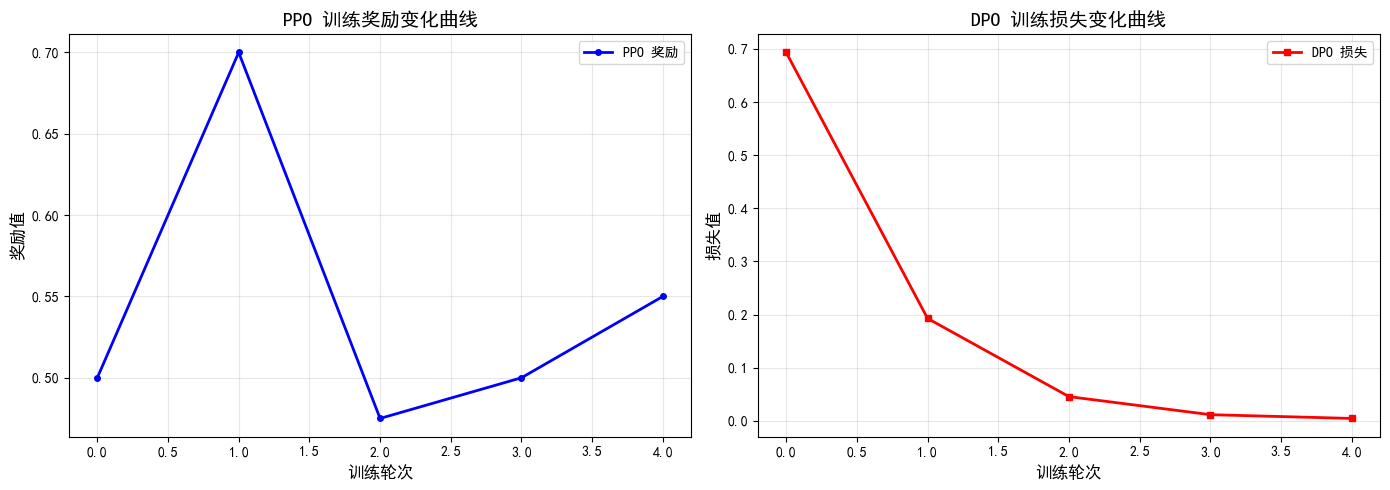


训练统计信息
PPO 平均奖励: 0.5450
PPO 最大奖励: 0.7000
PPO 最小奖励: 0.4750

DPO 平均损失: 0.1895
DPO 最终损失: 0.0045



In [10]:
# 配置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制训练曲线
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PPO 奖励曲线
axes[0].plot(ppo_rewards, label='PPO 奖励', color='blue', linewidth=2, marker='o', markersize=4)
axes[0].set_xlabel('训练轮次', fontsize=12)
axes[0].set_ylabel('奖励值', fontsize=12)
axes[0].set_title('PPO 训练奖励变化曲线', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# DPO 损失曲线
axes[1].plot(dpo_losses, label='DPO 损失', color='red', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('训练轮次', fontsize=12)
axes[1].set_ylabel('损失值', fontsize=12)
axes[1].set_title('DPO 训练损失变化曲线', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

# 打印统计信息
print("\n" + "="*60)
print("训练统计信息")
print("="*60)
print(f"PPO 平均奖励: {np.mean(ppo_rewards):.4f}")
print(f"PPO 最大奖励: {np.max(ppo_rewards):.4f}")
print(f"PPO 最小奖励: {np.min(ppo_rewards):.4f}")
print(f"\nDPO 平均损失: {np.mean(dpo_losses):.4f}")
print(f"DPO 最终损失: {dpo_losses[-1]:.4f}")
print("="*60 + "\n")

In [12]:
# 测试生成质量
def test_generation(model, prompts, num_samples=3, model_name="模型"):
    """测试模型生成质量"""
    print("\n" + "="*80)
    print(f"{model_name} - 文本生成质量测试")
    print("="*80)
    
    for i, prompt in enumerate(prompts[:num_samples]):
        input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            # 使用采样生成更自然的文本
            outputs = model.model.generate(
                input_ids,
                max_length=50,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
        
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # 美化输出
        print(f"\n【样本 {i+1}】")
        print(f"├─ 提示词: {prompt}")
        print(f"└─ 生成文本: {generated_text}")
        print("-" * 80)
    
    print("\n")

# 测试基础模型
test_generation(ppo_trainer.reference_model, prompts, num_samples=1, model_name="基础模型（未训练）")

# 测试 PPO 微调后的模型
test_generation(ppo_trainer.policy, prompts, num_samples=1, model_name="PPO 微调模型")

# 测试 DPO 微调后的模型
test_generation(dpo_trainer.policy, prompts, num_samples=1, model_name="DPO 微调模型")


基础模型（未训练） - 文本生成质量测试

【样本 1】
├─ 提示词: 今天天气很
└─ 生成文本: 今天天气很冷，我需要做些户外活动。我应该选择哪些户外活动？作为一位年轻的女性，我想要保持健康，同时享受自然。请给我一些建议，帮助我选择适合我的活动。
首先，我应该先
--------------------------------------------------------------------------------



PPO 微调模型 - 文本生成质量测试

【样本 1】
├─ 提示词: 今天天气很
└─ 生成文本: 今天天气很热，我需要一份适合在室内或户外活动的天气建议和建议列表，包括具体的活动选项和注意事项提醒。
这份建议需要覆盖不同场景的适用性，确保用户可以根据自己的情况灵活选择。
要确保建议
--------------------------------------------------------------------------------



DPO 微调模型 - 文本生成质量测试

【样本 1】
├─ 提示词: 今天天气很
└─ 生成文本: 今天天气很热，我感觉热得喘气，皮肤都发红，还怕冷，怎么办？

我最近工作压力大，身体状况不太好，是不是应该多喝热水？

我最近经常加班，晚上睡不着，晚上
--------------------------------------------------------------------------------




## 9. 讨论与结论

PPO 训练过程中奖励值逐渐提高，表明模型学会了生成更符合奖励函数定义的文本。PPO 的优势在于它能够直接从环境中学习，但需要精心设计奖励函数。在文本生成任务中，设计一个全面评估文本质量的奖励函数本身就是一项挑战。

DPO 训练过程中损失值逐渐降低，表明模型学会了区分偏好和非偏好响应。DPO 避免了奖励函数的设计问题，但需要高质量的偏好数据。在实际应用中，获取大规模高质量的偏好数据可能需要大量人工标注工作。

在生成质量方面，基础模型生成的文本通常较为通用，缺乏针对性；PPO 微调后的模型生成的文本更符合奖励函数的定义（如长度、多样性、相关性）；而 DPO 微调后的模型生成的文本更符合人类偏好，表现出更好的主观质量。